In [2]:
import torch
import time
import numpy as np
import sys
sys.path.append('src')
import sigkernel
import matplotlib.pyplot as plt
from sigkernel.transformers import AddTime
import seaborn as sns

# Using seaborn's style
plt.style.use('seaborn-colorblind')
width = 345
tex_fonts = {
    "text.usetex": False,
    "font.family": "serif",
    "axes.labelsize": 24,
    "font.size": 22,
    "legend.fontsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'figure.figsize': (7, 5),
}
plt.rcParams.update(tex_fonts)

In [17]:
# number of path coordinates and number of time steps
D, L = 1, 3 

# experimental setup
repeats, n_samples, n, lambda_ = 100, 500, 1e5, 1e-3

MMD_0 = np.zeros((repeats,2))
MMD_1 = np.zeros((repeats,2))

# to store the sample paths from X_n and X
X = np.zeros((repeats,n_samples,2,L,D)) 
X_n = np.zeros((repeats,n_samples,2,L,D))   

# sample from X_n 
omega_1 = np.random.choice(a=[-1, 1],size=(repeats, n_samples,2))
omega_2 = np.random.choice(a=[-1, 1],size=(repeats, n_samples,2))
X_n[:,:,:,1,0] = omega_1*1./n
X_n[:,:,:,2,0] = 0.1*omega_1

# sample from X
omega_1 = np.random.choice(a=[-1, 1],size=(repeats, n_samples,2))
X[:,:,:,2,0] = 0.1*omega_1

In [18]:
# setup the signature kernel

dyadic_order = 2
dyadic_order_1 = 1

_naive_solver=False

static_kernel = sigkernel.RBFKernel(sigma=1e-5,add_time=L-1)
static_kernel_1 = sigkernel.RBFKernel(sigma=2.,add_time=L-1)

signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order, _naive_solver, static_kernel_1, dyadic_order_1)

In [19]:
# run the experiment
for i in range(repeats):
    x0 = torch.tensor(X[i,:,0,:,:], dtype=torch.float64).cuda()     # X of shape (repeats,n_samples,2,L,D)
    x0_ = torch.tensor(X[i,:,1,:,:], dtype=torch.float64).cuda()    # independent copy of X
    xn = torch.tensor(X_n[i,:,0,:,:], dtype=torch.float64).cuda()
    xn_ = torch.tensor(X_n[i,:,1,:,:], dtype=torch.float64).cuda()  # independent copy of X_n

    MMD_1[i,0] = signature_kernel.compute_mmd_rank_1(x0,x0_,lambda_, estimator='ub') 
    MMD_1[i,1] = signature_kernel.compute_mmd_rank_1(xn,x0,lambda_, estimator='ub')  
    
    MMD_0[i,0] = signature_kernel.compute_mmd(x0,x0_, estimator='ub')
    MMD_0[i,1] = signature_kernel.compute_mmd(xn,x0,estimator='ub')

In [ ]:
# for i in range(50):
#   plt.plot(X[0,i,0,:,0],c='b',alpha=0.5)
#   plt.plot(X_n[0,i,0,:,0],c='r',alpha=0.5)
# plt.show()

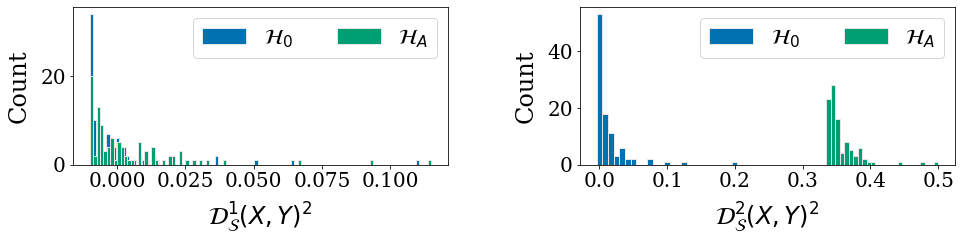

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,5))


ax[0].hist(MMD_0[:,0], bins=100, label=r'$\mathcal{H}_0$',edgecolor='#E6E6E6')
ax[0].hist(MMD_0[:,1], bins=100,label=r'$\mathcal{H}_A$',edgecolor='#E6E6E6')

ax[0].legend(loc='upper right',ncol=2,fontsize=22)
ax[0].set_xlabel(r'$\mathcal{D}^1_{\mathcal{S}}(X,Y)^2$',labelpad=10)
ax[0].set_ylabel('Count',labelpad=10)

ax[1].hist(MMD_1[:,0], bins=25, label=r'$\mathcal{H}_0$',edgecolor='#E6E6E6')
ax[1].hist(MMD_1[:,1], bins=25,label=r'$\mathcal{H}_A$',edgecolor='#E6E6E6')

ax[1].legend(loc='upper right',ncol=2,fontsize=22)
ax[1].set_xlabel(r'$\mathcal{D}^2_{\mathcal{S}}(X,Y)^2$',labelpad=10)
ax[1].set_ylabel('Count',labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary.pdf',bbox_inches='tight')
plt.show()